# GANs on MNIST

Generative Adversarial Networks (GANs) are:

- **Generator:** Produces fake images
- **Discriminator:** Determines real vs fake
- **Training:** Adversarial min-max game

We will demonstrate:

1. Vanilla GAN (fully connected)
2. DCGAN (convolutional)

Key classroom adjustments:

- Smaller networks for CPU
- Fewer epochs
- Visualize generated digits every epoch


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MNIST

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [2]:
# Build DCGAN Generator

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,128)))
    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='tanh'))
    return model

# Build DCGAN Discriminator

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,5,strides=2,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [3]:
# Train Function 

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)


Epoch 1, Gen Loss: 1.7278, Disc Loss: 0.6506, Time: 47.54s


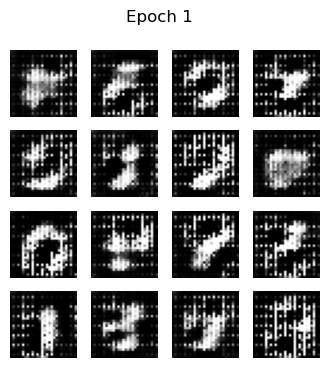

Epoch 2, Gen Loss: 1.2564, Disc Loss: 0.7837, Time: 47.95s


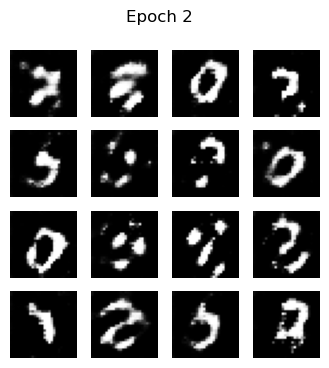

Epoch 3, Gen Loss: 1.4387, Disc Loss: 0.8823, Time: 46.92s


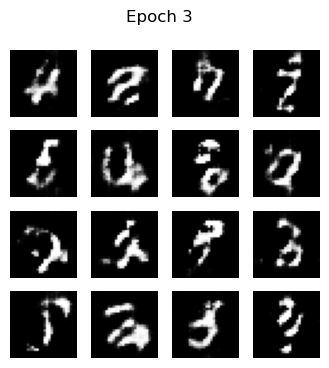

Epoch 4, Gen Loss: 1.0628, Disc Loss: 0.9299, Time: 47.56s


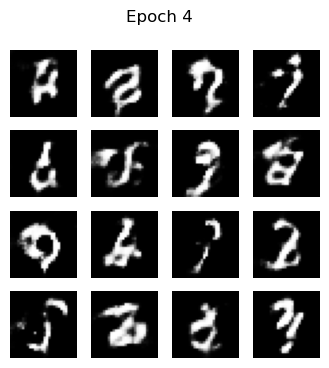

Epoch 5, Gen Loss: 1.1182, Disc Loss: 1.3232, Time: 47.55s


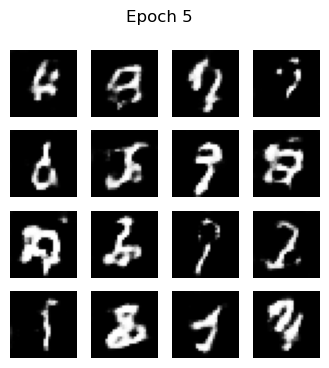

Epoch 6, Gen Loss: 1.2358, Disc Loss: 1.1750, Time: 46.52s


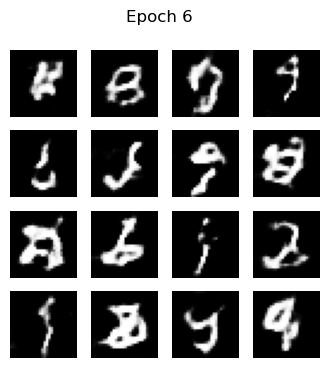

Epoch 7, Gen Loss: 1.1980, Disc Loss: 1.1169, Time: 47.54s


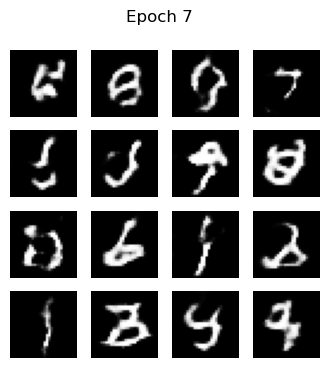

Epoch 8, Gen Loss: 0.9675, Disc Loss: 1.3036, Time: 46.87s


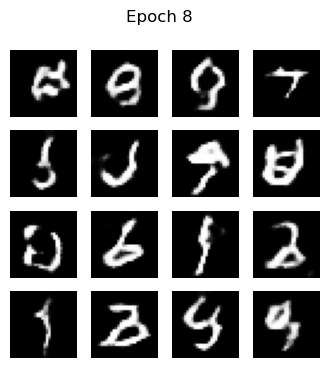

Epoch 9, Gen Loss: 0.9456, Disc Loss: 1.2494, Time: 47.46s


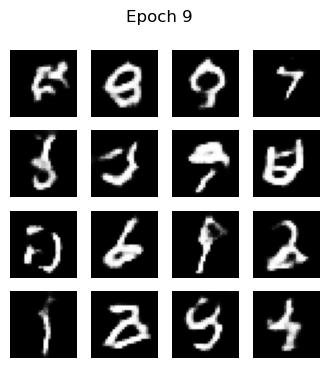

Epoch 10, Gen Loss: 1.0904, Disc Loss: 1.1903, Time: 47.29s


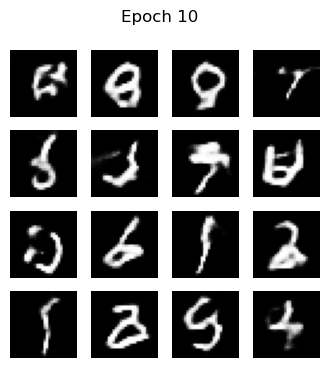

In [4]:
# Training Loop

import time

EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
        print(f'Epoch {epoch+1}, Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}, Time: {time.time()-start:.2f}s')
        # Visualize
        generate_and_save_images(generator, epoch+1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i,:,:,0]+1)/2, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

train(train_dataset, EPOCHS)